<a href="https://colab.research.google.com/github/DrDumbenstein/Behavioural-Clonning-Self-driving-car/blob/master/Behavoural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/DrDumbenstein/Behavioural-Clonning-Self-driving-car


In [0]:
!pip3 install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [0]:
datadir = "Behavioural-Clonning-Self-driving-car"
colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
pd.set_option('display.max_colwidth', -1)
data.head()

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()



In [0]:
num_bins = 25
samples_per_bin = 3000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.2
plt.bar(center, hist, width = 0.02)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [0]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2] 
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  
    
    

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training Samples: {} \nValid Samples: {}'.format(len(X_train), len(X_valid)))

In [0]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale =(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = npimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed_image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = npimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')
axs[1].imshow(panned_image)
axs[1].set_title('panned_image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image
  

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = npimg.imread(image)
brightness_image = img_random_brightness(original_image)
fig, axs = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original')
axs[1].imshow(brightness_image)
axs[1].set_title('brightness_altered_image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = - steering_angle
  return image, steering_angle
   

In [0]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = npimg.imread(image)
flipped_image,flipped_steering_angle = img_random_flip(original_image, steering_angle)
fig, axs = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('flipped_image' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = npimg.imread(image)
  
  if np.random.rand() < 0.5 :
    image = pan(image)
  if np.random.rand() < 0.5 :
    image = zoom(image)
  if np.random.rand() < 0.5 :
    image = img_random_brightness(image)
  if np.random.rand() < 0.5 :
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle
  

In [0]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize = (15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = npimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('original image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('augmented image')
  
  

In [0]:
def image_preprocess(img):
  
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img
  

In [0]:
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = image_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original_image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprossed image')


In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = npimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
        
      im =  image_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))
      
    
       

In [0]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1,2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validaion image')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), subsample = (2,2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, (5, 5), subsample = (2,2), activation = 'elu'))
  model.add(Convolution2D(48, (5, 5), subsample = (2,2), activation = 'elu'))
  model.add(Convolution2D(64, (3, 3), activation = 'elu'))
  model.add(Convolution2D(64, (3, 3), activation = 'elu'))
  
  
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  
  
  model.add(Dense(50, activation = 'elu'))
 
  
  model.add(Dense(10, activation = 'elu'))
   
  
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-4)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

In [0]:
model = nvidia_model()
print(model.summary())

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, batch_size = 100, istraining = 1), steps_per_epoch = 300, epochs = 10, validation_data = batch_generator(X_valid, y_valid, batch_size = 100, istraining = 0), validation_steps = 200, verbose = 1, shuffle = 1 )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 464s 2s/step - loss: 0.0851 - val_loss: 0.0788
Epoch 2/10
300/300 [==============================] - 458s 2s/step - loss: 0.0799 - val_loss: 0.0749
Epoch 3/10
300/300 [==============================] - 456s 2s/step - loss: 0.0719 - val_loss: 0.0637
Epoch 4/10
300/300 [==============================] - 456s 2s/step - loss: 0.0636 - val_loss: 0.0601
Epoch 5/10
300/300 [==============================] - 457s 2s/step - loss: 0.0613 - val_loss: 0.0598
Epoch 6/10
300/300 [==============================] - 459s 2s/step - loss: 0.0591 - val_loss: 0.0538
Epoch 7/10
300/300 [==============================] - 459s 2s/step - loss: 0.0568 - val_loss: 0.0563
Epoch 8/10
300/300 [==============================] - 458s 2s/step - loss: 0.0548 - val_loss: 0.0491
Epoch 9/10
300/300 [==============================] - 454s 2s/step - loss: 0.0528 - val_loss: 0.0492
Epoch 10/10
300/300 [======================

Text(0.5, 0, 'epochs')

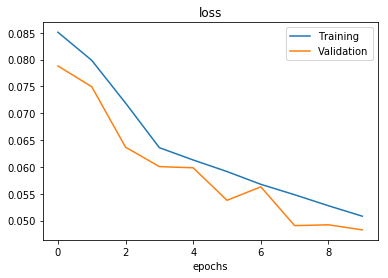

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('loss')
plt.xlabel('epochs')

In [0]:
model.save('model.h5')


In [0]:
 from google.colab import files
 files.download('model.h5')